In [101]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [2]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

filename = "Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:400])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wood


In [3]:
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [4]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [5]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [7]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [8]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [9]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [10]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [11]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [12]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = 'Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [13]:
print('Dataset: %d' % len(train))

Dataset: 6000


In [14]:
# load testing dataset 1K)
filename = 'Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

Dataset: 1000


In [15]:
# load validation dataset 1K)
filename = 'Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
validation = load_set(filename)
print('Dataset: %d' % len(validation))

Dataset: 1000


In [16]:
# Below path contains all the images
images = 'Flickr_Data/Flickr_Data/Images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [17]:
print(img[0])

Flickr_Data/Flickr_Data/Images\1000268201_693b08cb0e.jpg


In [18]:
# Below file conatains the names of images to be used in train data
train_images_file = 'Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [19]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [20]:
# Below file conatains the names of images to be used in test data
validation_images_file = 'Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
# Read the validation image names in a set# Read the test image names in a set
validation_images = set(open(validation_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
validation_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in validation_images: # Check if the image belongs to test set
        validation_img.append(i) # Add it to the list of test images

In [21]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [22]:
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [23]:
# descriptions
validation_descriptions = load_clean_descriptions('descriptions.txt', validation)
print('Descriptions: validation=%d' % len(validation_descriptions))

Descriptions: validation=1000


In [24]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [25]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [27]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image1 = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image1) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [28]:
train_img[0]

'Flickr_Data/Flickr_Data/Images\\1000268201_693b08cb0e.jpg'

In [29]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 791.6635348796844


In [30]:
import pickle
from pickle import dump, load

In [31]:
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [32]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 109.17210078239441


In [33]:
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [34]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_validation = {}
for img in validation_img:
    encoding_validation[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 109.24166369438171


In [35]:
# Save the bottleneck test features to disk
with open("encoded_validation_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_validation, encoded_pickle)

In [36]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [37]:
test_features = load(open("encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [38]:
validation_features = load(open("encoded_validation_images.pkl", "rb"))
print('Photos: validation=%d' % len(validation_features))

Photos: validation=1000


In [39]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [40]:
# Create a list of all the testing captions
all_test_captions = []
for key, val in test_descriptions.items():
    for cap in val:
        all_test_captions.append(cap)
len(all_test_captions)

5000

In [41]:
# Create a list of all the testing captions
all_validation_captions = []
for key, val in validation_descriptions.items():
    for cap in val:
        all_validation_captions.append(cap)
len(all_validation_captions)

5000

In [42]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [43]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [44]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [45]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [46]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [47]:
# Load Glove vectors
glove_dir = 'glove.6B'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [48]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [49]:
embedding_matrix.shape

(1652, 200)

In [50]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [51]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [52]:
model.layers[2]

In [53]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [54]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [55]:
print(len(train_descriptions))

6000


In [56]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [57]:
print(steps)

2000


In [58]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [59]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
model.fit_generator(generator, epochs=10, steps_per_epoch=steps, verbose=1) 

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2000/2000 [==============================] - 289s 144ms/step - loss: 4.1280
Epoch 2/10
2000/2000 [==============================] - 298s 149ms/step - loss: 3.4144
Epoch 3/10
2000/2000 [==============================] - 304s 152ms/step - loss: 3.1946
Epoch 4/10
2000/2000 [==============================] - 422s 211ms/step - loss: 3.0649
Epoch 5/10
2000/2000 [==============================] - 530s 265ms/step - loss: 2.9692
Epoch 6/10
2000/2000 [==============================] - 530s 265ms/step - loss: 2.8997
Epoch 7/10
2000/2000 [==============================] - 532s 266ms/step - loss: 2.8423
Epoch 8/10
2000/2000 [==============================] - 528s 264ms/step - loss: 2.7966
Epoch 9/10
2000/2000 [==============================] - 524s 262ms/step - loss: 2.7584
Epoch 10/10
2000/2000 [==============================] - 525s 262ms/step - loss: 2.7226


In [60]:
model.optimizer.lr = 0.0001
epochs = 20
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [61]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [62]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
model.fit_generator(generator, epochs=50, steps_per_epoch=steps, verbose=1) 

Epoch 1/50
1000/1000 [==============================] - 384s 384ms/step - loss: 2.6566
Epoch 2/50
1000/1000 [==============================] - 385s 385ms/step - loss: 2.6299
Epoch 3/50
1000/1000 [==============================] - 385s 385ms/step - loss: 2.6073
Epoch 4/50
1000/1000 [==============================] - 387s 387ms/step - loss: 2.5885
Epoch 5/50
1000/1000 [==============================] - 386s 386ms/step - loss: 2.5684
Epoch 6/50
1000/1000 [==============================] - 298s 298ms/step - loss: 2.5517
Epoch 7/50
1000/1000 [==============================] - 279s 279ms/step - loss: 2.5320
Epoch 8/50
1000/1000 [==============================] - 236s 236ms/step - loss: 2.5164
Epoch 9/50
1000/1000 [==============================] - 236s 236ms/step - loss: 2.5045
Epoch 10/50
1000/1000 [==============================] - 236s 236ms/step - loss: 2.4887
Epoch 11/50
1000/1000 [==============================] - 237s 237ms/step - loss: 2.4770
Epoch 12/50
1000/1000 [==================

In [84]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [85]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [86]:
def predict():
    predicted_descriptions = dict()
    for i in range(0, len(encoding_test)):
        pic = list(encoding_test.keys())[i]
        image = encoding_test[pic].reshape((1,2048))
        caption = greedySearch(image)
        predicted_descriptions[pic.partition('.')[0]] = caption
    return predicted_descriptions

In [87]:
predicted_descriptions = predict()

In [88]:
predicted_descriptions

{'1056338697_4f7d7ce270': 'man in black shirt and jeans stands between two huge',
 '106490881_5a2dd9b7bd': 'boy in floral swim trunks is splashing in the ocean',
 '1082379191_ec1e53f996': 'man in black shirt is standing on top of the railing overlooking the water',
 '1084040636_97d9633581': 'dog is running through the grass',
 '1096395242_fc69f0ae5a': 'the little boy is wearing red shirt and holding red and blue baseball',
 '1107246521_d16a476380': 'dog is running through the grass',
 '1119015538_e8e796281e': 'dog is running through the grass',
 '1122944218_8eb3607403': 'the boy is wearing red shirt and has his ears raised wide eyes',
 '1131800850_89c7ffd477': 'dog swims through the water',
 '1131932671_c8d17751b3': 'young boy in red shirt is climbing rock wall',
 '113678030_87a6a6e42e': 'man in red suit is sitting on top of snow covered mountain',
 '114051287_dd85625a04': 'man in black and yellow shirt is smiling',
 '115684808_cb01227802': 'two people are riding their way across the s

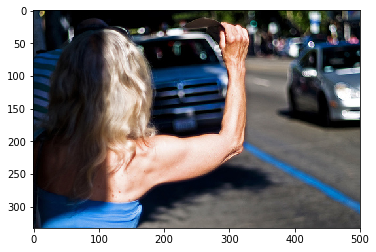

Greedy: man in black shirt and jeans stands between two huge


In [89]:
z=0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

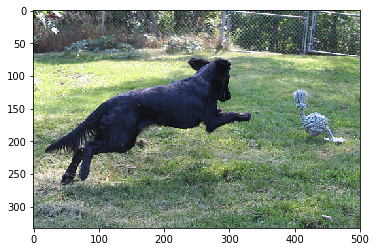

Greedy: dog is running through the grass


In [69]:
z=5
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

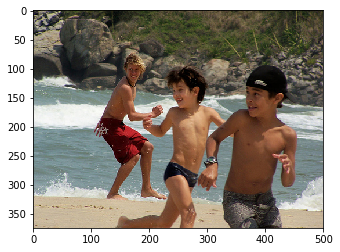

Greedy: two boys are hugging each other in the water


In [70]:
z=77
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

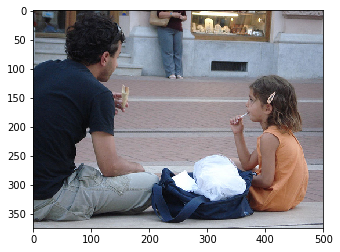

Greedy: group of children sit on chairs


In [71]:
z=100
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

2054869561_ff723e9eab.jpg
[[0.30333865 0.39193705 0.1577275  ... 0.32445127 0.53778994 0.24216402]]


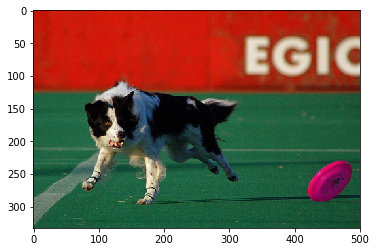

Greedy: dog is running through the grass


In [72]:
z=111
pic = list(encoding_test.keys())[z]
print(pic)
image = encoding_test[pic].reshape((1,2048))
print(image)
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [90]:
image_names = [i for i in train_features.keys()]
train_features[image_names[0]], len(train_features[image_names[0]])

(array([0.12277613, 0.33294898, 0.7527177 , ..., 0.21939686, 0.30216414,
        0.40283263], dtype=float32), 2048)

In [91]:
test_image_names = [i for i in test_features.keys()]
test_features[test_image_names[0]], len(test_features[test_image_names[0]])

(array([0.45309258, 0.25752294, 0.11301468, ..., 1.1222706 , 0.34380302,
        1.0150958 ], dtype=float32), 2048)

In [92]:
predicted_descriptions

{'1056338697_4f7d7ce270': 'man in black shirt and jeans stands between two huge',
 '106490881_5a2dd9b7bd': 'boy in floral swim trunks is splashing in the ocean',
 '1082379191_ec1e53f996': 'man in black shirt is standing on top of the railing overlooking the water',
 '1084040636_97d9633581': 'dog is running through the grass',
 '1096395242_fc69f0ae5a': 'the little boy is wearing red shirt and holding red and blue baseball',
 '1107246521_d16a476380': 'dog is running through the grass',
 '1119015538_e8e796281e': 'dog is running through the grass',
 '1122944218_8eb3607403': 'the boy is wearing red shirt and has his ears raised wide eyes',
 '1131800850_89c7ffd477': 'dog swims through the water',
 '1131932671_c8d17751b3': 'young boy in red shirt is climbing rock wall',
 '113678030_87a6a6e42e': 'man in red suit is sitting on top of snow covered mountain',
 '114051287_dd85625a04': 'man in black and yellow shirt is smiling',
 '115684808_cb01227802': 'two people are riding their way across the s

In [93]:
test_descriptions

{'1056338697_4f7d7ce270': ['startseq blond woman in blue shirt appears to wait for ride endseq',
  'startseq blond woman is on the street hailing taxi endseq',
  'startseq woman is signaling is to traffic as seen from behind endseq',
  'startseq woman with blonde hair wearing blue tube top is waving on the side of the street endseq',
  'startseq the woman in the blue dress is holding out her arm at oncoming traffic endseq'],
 '106490881_5a2dd9b7bd': ['startseq boy in his blue swim shorts at the beach endseq',
  'startseq boy smiles for the camera at beach endseq',
  'startseq young boy in swimming trunks is walking with his arms outstretched on the beach endseq',
  'startseq children playing on the beach endseq',
  'startseq the boy is playing on the shore of an ocean endseq'],
 '1082379191_ec1e53f996': ['startseq lady and man with no shirt sit on dock endseq',
  'startseq man and woman are sitting on dock together endseq',
  'startseq man and woman sitting on dock endseq',
  'startseq

In [94]:
references = list()
for i in test_descriptions:
    references.append(test_descriptions[i])

In [95]:
references

[['startseq blond woman in blue shirt appears to wait for ride endseq',
  'startseq blond woman is on the street hailing taxi endseq',
  'startseq woman is signaling is to traffic as seen from behind endseq',
  'startseq woman with blonde hair wearing blue tube top is waving on the side of the street endseq',
  'startseq the woman in the blue dress is holding out her arm at oncoming traffic endseq'],
 ['startseq boy in his blue swim shorts at the beach endseq',
  'startseq boy smiles for the camera at beach endseq',
  'startseq young boy in swimming trunks is walking with his arms outstretched on the beach endseq',
  'startseq children playing on the beach endseq',
  'startseq the boy is playing on the shore of an ocean endseq'],
 ['startseq lady and man with no shirt sit on dock endseq',
  'startseq man and woman are sitting on dock together endseq',
  'startseq man and woman sitting on dock endseq',
  'startseq man and woman sitting on deck next to lake endseq',
  'startseq shirtless

In [96]:
candidates = list()
for i in predicted_descriptions:
    candidates.append(predicted_descriptions[i])

In [97]:
from nltk.translate.bleu_score import corpus_bleu,sentence_bleu

In [98]:
# bleu score
score1 = corpus_bleu(references, candidates)
score2 = sentence_bleu(references, candidates)

In [99]:
print(score1,score2)

0.480157310723085 0


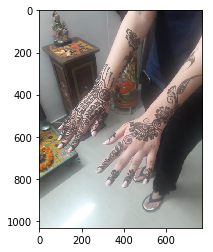

two girls in fancy dresses dance in the street


In [111]:
# pic = Image("a.jpeg")
pic = "p.jpeg"
x = plt.imread(pic)
encoded_img = encode(pic)
test_img = encoded_img.reshape(1,2048)
plt.imshow(x)
plt.show()
print(greedySearch(test_img))